In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xls_data=pd.read_excel("./table.xlsx")
t2_dat=xls_data.loc[:,"# of turns":"HFSS"]
t3_dat=xls_data.loc[:,"# of turns.1":"HFSS.1"]
t4_dat=xls_data.loc[:,"# of turns.2":"HFSS.2"]
t2_dat=t2_dat.replace(np.nan,0)
t3_dat=t3_dat.replace(np.nan,0)
t4_dat=t4_dat.replace(np.nan,0)

In [3]:
def data_restore(dat):
    for col_name in dat.columns[:5]:
        temp=0
        for i in range(len(dat[col_name])):
            if (dat.loc[i,col_name]!=0):
                temp=dat.loc[i,col_name]
            if (dat.loc[i,col_name]==0):
                dat.loc[i,col_name]=temp
    return dat
t2_dat=data_restore(t2_dat)
t3_dat=data_restore(t3_dat)
t4_dat=data_restore(t4_dat)

In [4]:
total_dat_temp=np.vstack([t2_dat.values,t3_dat.values,t4_dat.values])
del_index=np.where(total_dat_temp[:,6]==0)[0]
total_dat_temp=pd.DataFrame(total_dat_temp,columns=t2_dat.columns)
total_dat=total_dat_temp.drop(del_index)
total_dat.to_csv("preprocessed_data.csv",
                 columns=total_dat.columns,sep=",", index=False)
data=total_dat.values

In [5]:
dat_x = data[:,:6]
max_x = np.max(dat_x,axis=0)
dat_x = dat_x/max_x
dat_y = data[:,6]
log_dat_x=np.log(dat_x)
log_dat_y=np.log(dat_y)
n_data = len(dat_y)

In [6]:
x_train = np.hstack( ( np.ones((n_data,1)), log_dat_x, dat_x ) )
y_train = log_dat_y

---

## Model

We assume 

$$
\log(v) \approx b + \sum_{i=1}^{6}\left( \theta_i \log u_i + \beta_i u_i \right)
$$

or,

$$
    v \approx e^b \prod_{i=1}^{6}u_i^{\theta_i} (e^{\beta_i})^{u_i}
$$

where

- $u_1$: n_turns/4 
- $u_2$: permitivity_surface/50
- $u_3$: LS_LW/0.3
- $u_4$: SEP/0.6
- $u_5$: permitivity_subsidence/8
- $u_6$: OD/32
- $v$: HFSS
- decision variables: $b$, $\theta_1, \dots, \theta_6$, $\beta_1, \dots, \beta_6$


## Least squares solution

Solve

$$
    \text{minimize}\quad  \| X_\text{train}\theta-y_\text{train} \|^2 
$$

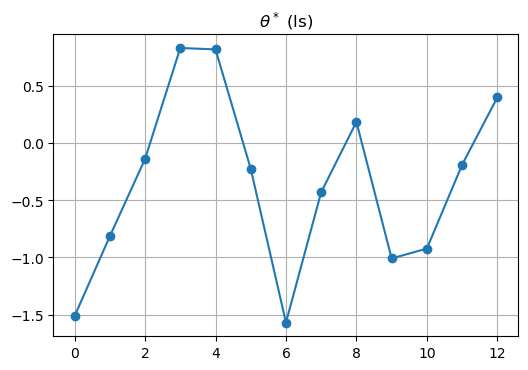

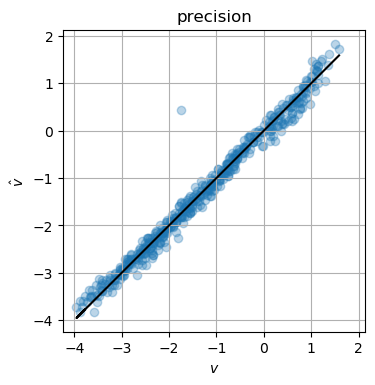

MSE: 0.0316925543521681
RMSE: 0.17802402745744209
Percentage error: 19.485403019425785 %


In [7]:
theta_ls = np.linalg.lstsq(x_train,y_train,rcond=None)[0]
y_pred = x_train.dot(theta_ls)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.plot(theta_ls,'o-')
plt.grid()
plt.title(r'$\theta^*$ (ls)')
plt.show()

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.title('precision')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')


___

### Outlier rejection

In [8]:
# finding the outlier
np.argmax(y_pred-y_train)

100

In [9]:
# remove it
x_train = np.delete(x_train,100,0)
y_train = np.delete(y_train,100,0)
n_data = len(y_train)

Solution with outlier rejected:

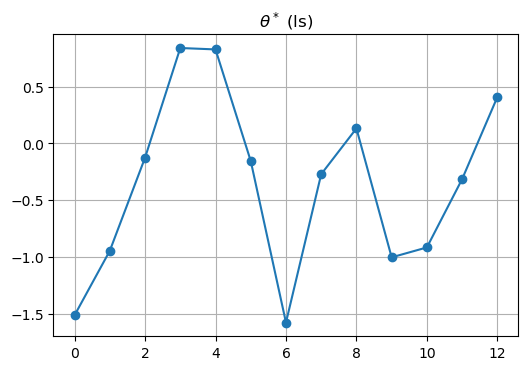

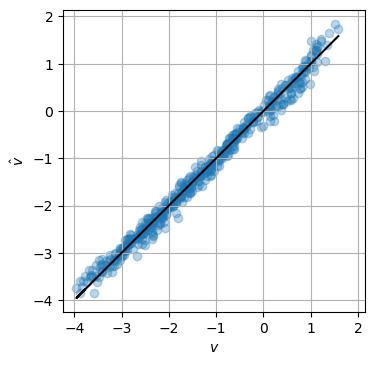

MSE: 0.021353756695325573
RMSE: 0.14612924654334455
Percentage error: 15.734576132377942 %


In [10]:
theta_ls = np.linalg.lstsq(x_train,y_train,rcond=None)[0]
y_pred = x_train.dot(theta_ls)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.plot(theta_ls,'o-')
plt.grid()
plt.title(r'$\theta^*$ (ls)')
plt.show()

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')


### Sparse modeling

Solve

$$
    \text{minimize}\quad  \| X_\text{train}\theta-y_\text{train} \|^2 + \gamma\|\theta_{2:d}\|_1
$$

In [11]:
import cvxpy as cp

gamma = cp.Parameter(nonneg=True)
theta = cp.Variable(x_train.shape[1])
err = cp.sum_squares(x_train*theta-y_train)/n_data

obj = cp.Minimize( cp.sum_squares(y_train-x_train*theta) + gamma*cp.norm(theta[1:],1) )
prob = cp.Problem(obj)

gamma_vals = np.logspace(-3,1,100)
mse = []
card = []

for val in gamma_vals:
    gamma.value = val
    prob.solve(solver=cp.ECOS, verbose=False)
    mse.append(err.value)
    card.append(np.sum((abs(theta.value)>1e-6)))


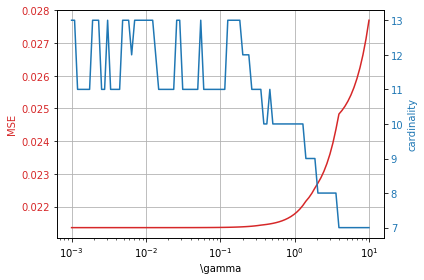

In [12]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'\gamma')
ax1.set_ylabel('MSE', color=color)
ax1.semilogx(gamma_vals, mse, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('cardinality', color=color)  
ax2.semilogx(gamma_vals, card, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

### we choose $\gamma=1.5$

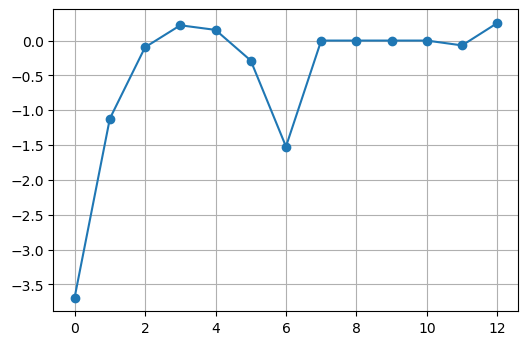

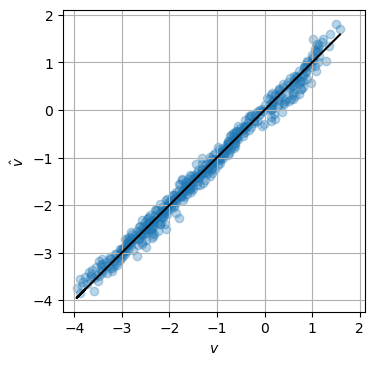

MSE: 0.022227751744498436
RMSE: 0.14908974392793903
Percentage error: 16.07771572363439 %


In [15]:
import cvxpy as cp

theta = cp.Variable(x_train.shape[1])
obj = cp.Minimize( cp.sum_squares(y_train-x_train*theta) + 1.5*cp.norm(theta[1:],1) )

prob = cp.Problem(obj)
prob.solve(solver=cp.ECOS, verbose=False)
theta_opt = theta.value

plt.figure(dpi=100)
plt.plot(theta_opt,'o-')
plt.grid()
plt.show()

y_pred = x_train.dot(theta_opt)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')

In [16]:
np.set_printoptions(precision=5)
print('b_opt:', theta_opt[0])
print('theta_opt:', theta_opt[1:7])
print('beta_opt:', theta_opt[7:])
print('b_opt_exp:', np.exp(theta_opt[0]))
print('beta_opt_exp:', np.exp(theta_opt[7:]))

b_opt: -3.6887313111246436
theta_opt: [-1.12079 -0.09603  0.21936  0.15316 -0.28663 -1.52151]
beta_opt: [-1.22086e-07  9.70790e-07  6.33391e-08  1.20561e-07 -6.94264e-02
  2.52067e-01]
b_opt_exp: 0.02500370384907518
beta_opt_exp: [1.      1.      1.      1.      0.93293 1.28668]


### Final model

$$
\log(HFSS) \approx -3.689 
-1.121\log{n} -0.09603\log{\lambda} +0.2194\log{L} +0.1532\log{d} -0.2866\log{\nu} -1.522\log{\alpha} 
-0.06943 e + 0.2521 f 
$$

or,

$$
    HFSS \approx 0.02500 n^{-1.121} \lambda^{-0.09603} L^{0.2194} d^{0.1532} \nu^{-0.2866} \alpha^{-1.522} 0.9329^\nu 1.2867^\alpha
$$

- $n$: n_turns/4 
- $\lambda$: permitivity_surface/50
- $L$: LS_LW/0.3
- $d$: SEP/0.6
- $\nu$: permitivity_subsidence/8
- $\alpha$: OD/32